In [6]:
## YOUR CODE HERE
import pandas as pd
import numpy as np
np.random.seed(2019)


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
import scikitplot as skplt
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [7]:
df = pd.read_hdf('../input/train.adult.h5')
df['target'] = df['Target'].factorize()[0]

In [8]:
def draw_feature_importances(model, X, y, feats):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(accuracy_score(y_test, y_pred))
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
            color="b", align="center")
    plt.xticks(range(X.shape[1]), [feats[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [9]:
#deleteing nan
df = df.fillna(-1)

In [10]:
cat_feats = df.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

In [19]:
df['Sex_Cat'] = df['Sex'].map(lambda x: int(x))
df['Is_White'] = df['Race'].map(lambda x: int(x =='White'))

merged = []
def isWhiteMaleMarried(row):
    if row['Sex_Cat']  == 1 and row['Is_White'] == 1 and row['Relationship'] == 'Husband':
        merged.append(1)
    else:
        merged.append(0)
df.apply(isWhiteMaleMarried, axis=1)


whiteMales = []
def IsWhiteMale(row):
    if row['Sex_Cat']  == 1 and row['Is_White'] == 1:
        whiteMales.append(1)
    else:
        whiteMales.append(0)
        
df.apply(IsWhiteMale, axis=1)


whiteWife = []
def isWhiteFemaleMarried(row):
    if row['Sex_Cat']  == 0 and row['Is_White'] == 1 and row['Relationship'] == 'Wife':
        whiteWife.append(1)
    else:
        whiteWife.append(0)
df.apply(isWhiteFemaleMarried, axis=1)
len(whiteWife)

32561

In [13]:
#feature engineering

married = ["Married-AF-spouse", "Married-civ-spouse"]
educated = ['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Assoc-voc', 'Assoc-acdm', 'Prof-school', 'Doctorate', 'Preschool']
df['G_Age'] = df['Age'].map(lambda x: int(60>x>34))
df['Full_Time'] = df['Hours per week'].map(lambda x: int(x>42))
df['Is_from_US']= df['Country'].map(lambda x: int(x=='United-States'))
df['Is_married'] = df['Martial Status'].map(lambda x: int(x in married))
# df.apply(isWhiteMaleMarried, axis=1)
df['Is_White_Husband'] = merged
df['Is_white_Male'] = whiteMales
df['Is_white_Wife'] = whiteWife
df['Is_Educated'] = df['Education'].map(lambda x: int(x in educated))
df['Is_Educated_Male'] =df.apply(lambda x: int(x['Is_Educated'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Asian'] = df['Race'].map(lambda x: int(x =='Asian-Pac-Islander'))
df['Is_Asian_Male'] = df.apply(lambda x: int(x['Is_Asian'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Bright'] = df.apply(lambda x: int(x['Is_Asian'] == 1 or x['Is_White'] == 1), axis=1)
df['Is_Bright_Male'] = df.apply(lambda x: int(x['Is_Bright'] == 1 and x['Sex_Cat'] == 1), axis=1)
df['Is_Self_Emp'] = df['Workclass'].map(lambda x: int(x=='Self-emp-inc'))



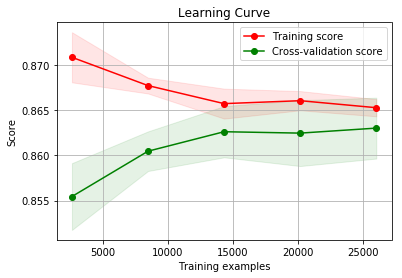

In [14]:
#### train model
feats = ['Age','G_Age' ,'Education-Num', 'Sex', 'Is_married','Is_White_Husband', 'Is_white_Wife', 'Full_Time', 
         'Is_Educated', 'Is_Educated_Male', 'Occupation_cat', 'Is_Bright','Workclass_cat', 'Capital Gain', 'Capital Loss', 
         'Country_cat']
X = df[feats].values
y = df['target'].values
# model = RandomForestClassifier(max_depth=10, n_estimators=200, random_state=2019)
model = XGBClassifier()
scores = cross_val_score(model, X, y, cv=5)
np.mean(scores), np.std(scores)
## learning curve
skplt.estimators.plot_learning_curve(model, X, y, cv=5);

In [17]:
np.mean(scores), scores, np.std(scores)

(0.8627192883180907,
 array([0.85997236, 0.8585688 , 0.86640049, 0.86455774, 0.86409705]),
 0.0029530179663066376)

0.8629337700890573


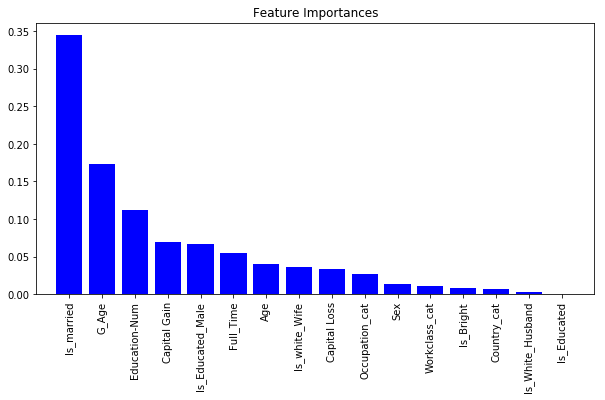

In [16]:
draw_feature_importances(model, X, y, feats)